# Introduction
In a [previous post](Intro2KBE.html), I describes the KGE models that are implemented as a part of DGL-KE. This blog provides  details about optimizations that are implemented by DGL-KE that makes it very efficient for multi-device and distributed training as well as providing an example that can be run on a laptop. 

# What is DGL-KE
DGL-KE is a high performance, easy-to-use, and scalable package for learning large-scale knowledge graph embeddings. DGL-KE contains a python package atop DGL in order to be able to take advantage of distributed graph operations implemented by DGL. DGL in turn takes advantage of popular deep learning libraries such as MXNet and Pytorch for performing tensor operations.
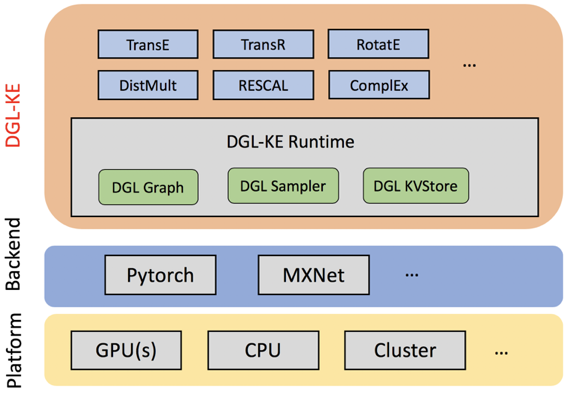

As illustrated in the picture above, DGL-KE implements some of the most popular knowledge embedding models such as TransE, TransR, RotateE, DistMulti, RESCAL, and ComplEx. More details about the models cab be found [here](http:./blogs/Intro2KBE.html). 
The models are implemented in python and rely on pytorch in order to run. The runtime includes DGL Graph for graph operations, DGL Sampler to perform sampling and triplets sampling, and a key-value pair in memory data store,DGL KVStore, specifically designed for DGL-KE to hold embedding in distributed training. The KV store has graph partitioning capabilities it uses to distribute graphs across multiple machines.

# Challenges Facing Knowledge Graph Embedding.


Real world problems results in three main challenges for knowledge embedding:
- Size: Some knowledge graphs could include millions of hundreds of millions of node, billion of edges, and tens of thousands of relations. Storing such enormous data structure and learning embeddings within it one of the challenges of KGE.
- Sparsity: As there are many more items than relations, knowledge graphs represent highly sparse data. Computing embedding and dimension reduction for extremely large sparse data is computationally expensive.
- Efficient distribution of large graphs as computationally independent subgraphs.

# DGL-KE Optimization Areas 
DGL-KE accelerates KGE training on knowledge graphs with millions of nodes and billions of edges using various deployment architectures and hardware profiles. DGL-KE implements various optimization and distribution innovations in order to :
- Increase data locality
- Reduce communication overhead.
- Overlap computations with memory access.
- Achieve high compute to memory density.

# Hardware Configurations
- Multi-core CPU, where several cores on the same machine are used for training.
- Multi-GPU, where several GPUs on the same machine are used.
- Multi-machine in a CPU/GPU cluster, where a cluster of GPU machines are used to train an embedding.

# Training Process
Training process involves two steps, assigning a set of distinct triplets to a process to form a mini-batch that can be trained independently and training a mini-batch.
Data distribution has different topologies depending on what sort of environment we want to run the KGE. 

For multicore CPU, knowledge graph structure, entity embeddings, and relation embeddings are all on the same CPU shared memory and CPUs fetch data from memory and update the gradients back to the shared memory. 

In case of multi-GPU training, as entity embeddings are too large to fit into GPU memory, they are kept on the CPU shared memory along with the KG structure. Relation embeddings, however, are loaded onto GPU memory in order to reduce data transfer. GPU processes, read the data from the shared memory and update the gradients on the CPU shared memory.

Cluster training is little bit different as we need to split the data and maximize locality per machine, so a kv-store server will be deployed across the training network and KG, structure, relation, and entity embeddings will be stored on the kv-store. kv-store automatically partitions the embedding, using a min-cut based graph partitioning method. The trainer prfocess, then uses *push* and *pull* API in order to fetch the data and send the gradients back. A short description of randomized min-cut is in the appendix A of this blog for those who want to know more about it.

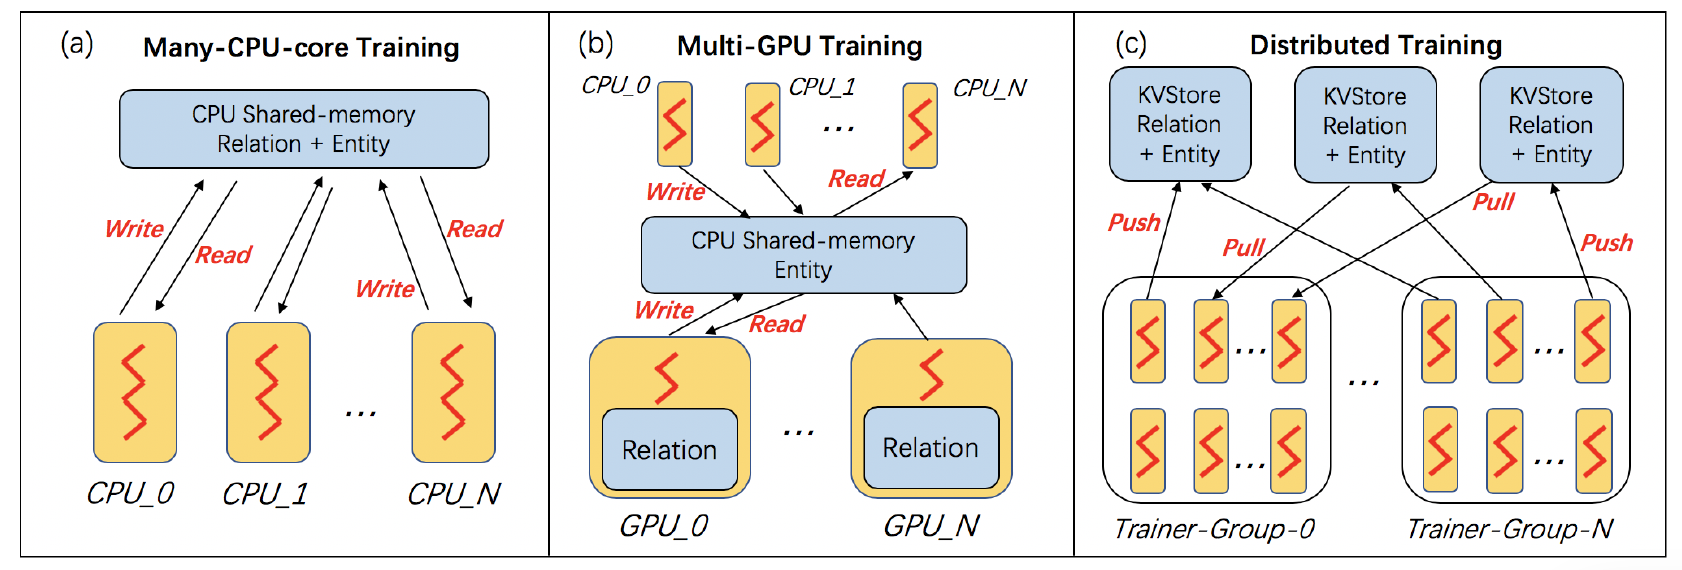

# Negative Sampling
DGL-KE constructs a large number of negative samples for each triplets. Sampling  is always performed on CPU and computation is offloaded to GPU, if GPU is available. In order to minimize data communication, only positive triplets are involved in creation and transferring of a batch. Negative samples are created based minibatch data and locally.

simply performing a uniform sample from heads and tails and ignoring degree of each node, the number of edges that are connected to a node, results in *easy* negative samples. As nodes with higher degree require more data for more patterns to be discovered about them, we perform negative sampling proportional to degree of nodes. This results in creating of *hard* negative samples. 
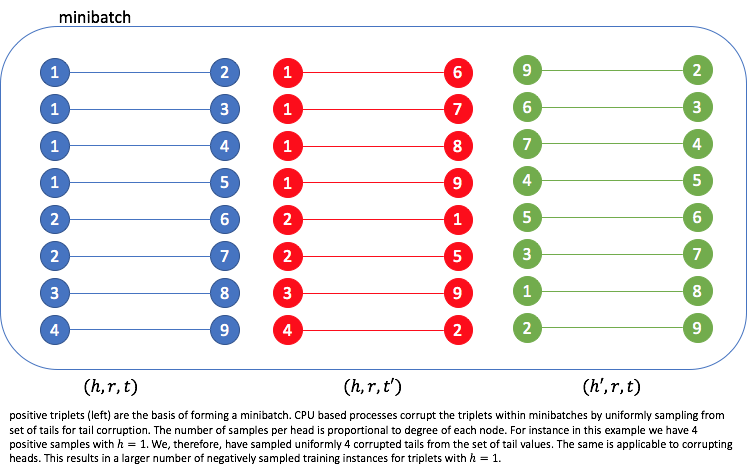

# Partitioning Relations
The larger the ratio of actual relations in a knowledge graph to the batch size ($\approx 1000$), the more sparse the relationship embedding will be. DGL-KE employs sparse relation embedding reads and sparse gradient update for communication efficiency. 
Additionally, to maximize localization, DGL-KE uses a load-balancing algorithm that minimized the number of distinct relations that are assigned to a partition.


# Overlapping Gradient Updates and GPU Idling Reduction
CPUs do process mini-batch creation and loading before sending them to GPUs for embeddings to be computed. This means if the process is run serially, the GPU has to wait for batch loader to finish first. To prevent GPU idling, DGL-KE mini batch for the next batch is computed while the current minibatch is processed by GPU. 
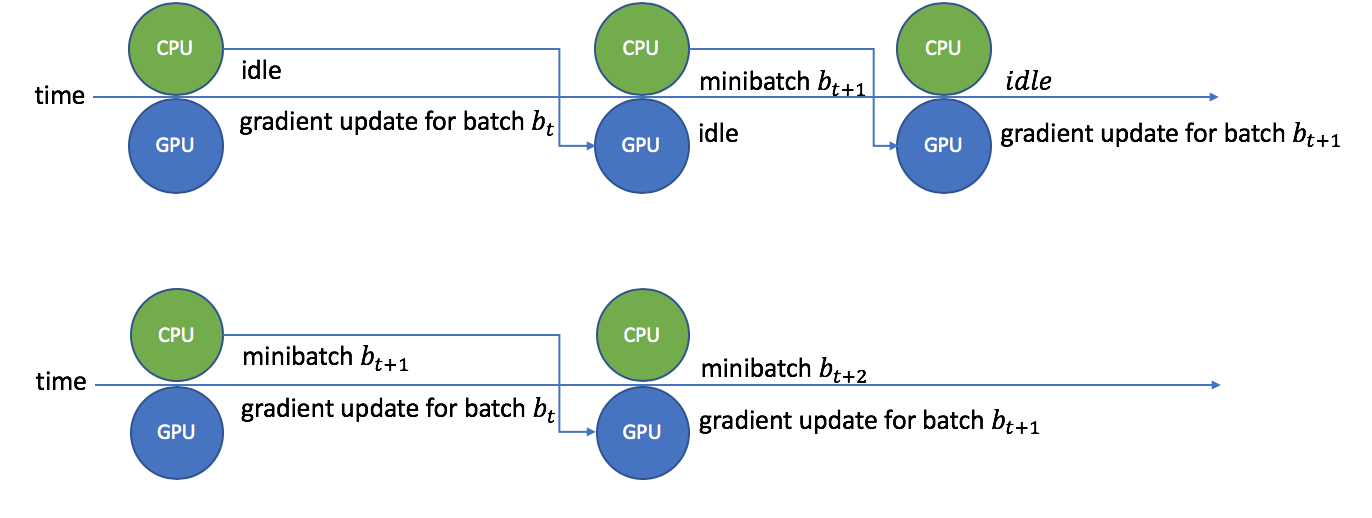
Additionally as the number of relations is usually much smaller than the number of entities, entity embeddings is separated from relation embedding and is offloaded to a dedicated process per trainer. 
Preventing GPU idling provide a 40% speedup for most of the KGE models on Freebase dataset.

# Training Your First KG
## Installing DGL-KE
if you have conda installed on your machine, create an environment using the following command:

```shell
:~$conda create -n dgl_pytorch python==3.8
:~$conda activate dgl_pytorch 
(dgl_pytorch)...:~$
```
Install appropriate version of pytorch on your machine. If you are using Mac, you can use 

```shell
(dgl_pytorch)...:~$conda install pytorch torchvision -c pytorch
```

I am using an ubunto machine with 4 GPUs and CUDA 10.0, so I am running:

```shell
(dgl_pytorch)...:~$conda install pytorch torchvision cudatoolkit=10 -c pytorch`
```
Test your installation


```shell
(dgl_pytorch)...:~$python --version` #should output Python 3.8.0
(dgl_pytorch)...:~$python
```
```python
>>>import torch
torch.__version__ #outputs the version number of pytorch you have installed. Mine is '1.5.0'
>>>quit()
```
Install `dgl` and `dglke`:
```shell
(dgl_pytorch)...:~$pip install dgl dglke
```
Test your installation
```shell
(dgl_pytorch)...:~$python
```
```python
>>> import dgl
>>> import dglke
>>> dgl.__version__, dglke.__version__ #It should output versions of dgl and dglke respectively. Mine is: ('0.4.3post2', '0.1.0')
>>>quit()
```

## Let's run a quick test
```shell
# create a new workspace
(dgl_pytorch)...:~$mkdir my_task && cd my_task
# Train transE model on FB15k dataset
(dgl_pytorch)...my_task:~$DGLBACKEND=pytorch 
(dgl_pytorch)...my_task:~$dglke_train --model_name TransE_l2 --dataset FB15k --batch_size 1000 \
--neg_sample_size 200 --hidden_dim 400 --gamma 19.9 --lr 0.25 --max_step 500 --log_interval 100 \
--batch_size_eval 16 -adv --regularization_coef 1.00E-09 --test --num_thread 1 --num_proc 8
```
```
-------------- Test result --------------
Test average MRR : 0.47339627234644155
Test average MR : 58.33693352067851
Test average HITS@1 : 0.2806791826784717
Test average HITS@3 : 0.6246889336561088
Test average HITS@10 : 0.7729342655448528
-----------------------------------------
```


## What did just happen?
First we set the backend of dgl to be pytorch. You could have chosen MXNet or Tensorflow. We then creating a training task using `dglke-train`. the training task is using `TransE` with `L2` loss, downloads `FB15k` dataset. We have instructed the model to build $k=200$ negative samples with $\gamma=400$ for embedding dimension.
`batch_size` is obviously 1000 with `batch_size_eval=16` as hyper-parameter used for the test.

# What's next?
Next we will implement a simple custom KGE task in a separate post.